In [1]:
import math
from collections import namedtuple
import os
import re
import datetime as dt
import json

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pprint import pprint

%matplotlib inline

### Define some helper methods and data structures

In [2]:
GeoExtent = namedtuple('GeoExtent', ['x_min', 'y_max', 'x_max', 'y_min'])
GeoAffine = namedtuple('GeoAffine', ['ul_x', 'x_res', 'rot_1', 'ul_y', 'rot_2', 'y_res'])
GeoCoordinate = namedtuple('GeoCoordinate', ['x', 'y'])
RowColumn = namedtuple('RowColumn', ['row', 'column'])
RowColumnExtent = namedtuple('RowColumnExtent', ['start_row', 'start_col', 'end_row', 'end_col'])
CONUS_EXTENT = GeoExtent(x_min=-2565585,
                         y_min=14805,
                         x_max=2384415,
                         y_max=3314805)
bands = ('blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal')
indices = ('ndvi', 'msavi', 'evi', 'savi', 'ndmi', 'nbr', 'nbr2')
band_info = {b: {'coefs': [], 'inter': [], 'pred': []} for b in bands}

### Required parameters manually entered here

In [3]:
JSON_DIR = r'Z:/sites/washington/pyccd-results/H05V02/2017.06.20/json'

CACHE_DIR = r'Z:/sites/washington/ARD/h05v02/cache'

arc_paste = '-1,720,611.345  2,965,296.192'

H = 5

V = 2

### Generate file inventory lists

In [4]:
JSON_INV = [os.path.join(JSON_DIR, f) for f in os.listdir(JSON_DIR)]

CACHE_INV = [os.path.join(CACHE_DIR, f) for f in os.listdir(CACHE_DIR)]

### Set time parameters

In [5]:
# These values are hardcoded for now
# May want to switch to determining these from the PyCCD results or ARD obs.
BEGIN_DATE = dt.date(year=1982, month=1, day=1)
END_DATE = dt.date(year=2015, month=12, day=31)

### Define all functions

In [6]:
def geospatial_hv(h, v, loc):
    """
    Geospatial extent and 30m affine for a given ARD grid location.
    """
    xmin = loc.x_min + h * 5000 * 30
    xmax = loc.x_min + h * 5000 * 30 + 5000 * 30
    ymax = loc.y_max - v * 5000 * 30
    ymin = loc.y_max - v * 5000 * 30 - 5000 * 30

    return (GeoExtent(x_min=xmin, x_max=xmax, y_max=ymax, y_min=ymin),
            GeoAffine(ul_x=xmin, x_res=30, rot_1=0, ul_y=ymax, rot_2=0, y_res=-30))

In [7]:
def geo_to_rowcol(affine, coord):
    """
    Transform geo-coordinate to row/col given a reference affine.
    
    Yline = (Ygeo - GT(3) - Xpixel*GT(4)) / GT(5)
    Xpixel = (Xgeo - GT(0) - Yline*GT(2)) / GT(1)
    """
    row = (coord.y - affine.ul_y - affine.ul_x * affine.rot_2) / affine.y_res
    col = (coord.x - affine.ul_x - affine.ul_y * affine.rot_1) / affine.x_res

    return RowColumn(row=int(row),
                     column=int(col))

In [8]:
def rowcol_to_geo(affine, rowcol):
    """
    Transform a row/col into a geospatial coordinate given reference affine.
    
    Xgeo = GT(0) + Xpixel*GT(1) + Yline*GT(2)
    Ygeo = GT(3) + Xpixel*GT(4) + Yline*GT(5)
    """
    x = affine.ul_x + rowcol.column * affine.x_res + rowcol.row * affine.rot_1
    y = affine.ul_y + rowcol.column * affine.rot_2 + rowcol.row * affine.y_res

    return GeoCoordinate(x=x, y=y)

In [9]:
def load_cache(file):
    """
    Load the cache file and split the data into the image IDs and values
    """
    data = np.load(file)
    return data['Y'], data['image_IDs']

In [10]:
def find_file(file_ls, string):
    """
    Return the first str in a list of strings that contains string.
    """
    gen = filter(lambda x: string in x, file_ls)
    return next(gen, None)

In [11]:
def imageid_date(image_ids):
    """
    Extract the ordinal day from the ARD image name.
    """
    return np.array([dt.datetime.strptime(d[15:23], '%Y%m%d').toordinal()
                     for d in image_ids])

In [12]:
def mask_daterange(dates):
    """
    Create a mask for values outside of the global BEGIN_DATE and END_DATE.
    :param dates:
    :return:
    """
    return np.logical_and(dates >= BEGIN_DATE.toordinal(), dates < END_DATE.toordinal())

In [13]:
def find_chipcurve(results_chip, coord):
    """
    Find the results for the specified coordinate.
    """
    with open(results_chip, 'r') as f:
        results = json.load(f)
    
    gen = filter(lambda x: coord.x == x['x'] and coord.y == x['y'], results)
    
    return next(gen, None)

In [14]:
def extract_cachepoint(coord):
    """
    Extract the spectral values from the cache file.
    """

    rowcol = geo_to_rowcol(PIXEL_AFFINE, coord)
    
    data, image_ids = load_cache(find_file(CACHE_INV, 'r{}'.format(rowcol.row)))
    
    dates = imageid_date(image_ids)
    
    return image_ids, data[:, :, rowcol.column], dates
   

In [15]:
def extract_jsoncurve(coord):
        """
        Extract the pyccd information from the json file representing a chip of results.
        """
        pixel_rowcol = geo_to_rowcol(PIXEL_AFFINE, coord)
        pixel_coord = rowcol_to_geo(PIXEL_AFFINE, pixel_rowcol)

        chip_rowcol = geo_to_rowcol(CHIP_AFFINE, coord)
        chip_coord = rowcol_to_geo(CHIP_AFFINE, chip_rowcol)

        file = find_file(JSON_INV,
                              "H{:02d}V{:02d}_{}_{}.json".format(H, V, chip_coord.x, chip_coord.y))
        result = find_chipcurve(file, pixel_coord)

        return json.loads(result["result"])

In [16]:
def predicts(days, coef, intercept):
    return (intercept + coef[0] * days +
            coef[1]*np.cos(days*1*2*np.pi/365.25) + coef[2]*np.sin(days*1*2*np.pi/365.25) +
            coef[3]*np.cos(days*2*2*np.pi/365.25) + coef[4]*np.sin(days*2*2*np.pi/365.25) +
            coef[5]*np.cos(days*3*2*np.pi/365.25) + coef[6]*np.sin(days*3*2*np.pi/365.25))

In [17]:
def arcpaste_to_coord(string):
    pieces = string.split()
    
    return GeoCoordinate(x=float(re.sub(',', '', pieces[0])),
                         y=float(re.sub(',', '', pieces[1])))

In [18]:
def test_data(end_date, dates_in, dates_out, data, dates, date_mask, ccd_mask):
    """
    Test the dates for the presence of duplicates, and compare both with and without duplicate counts to the number
    of observations in the PyCCD internal processing mask.  One possible source of duplicates is equal date
    observations from Landsat 7 and 8.  During Landsat 8's ascension into orbit there was a brief period of time
    where the two sensors 'overlapped' to allow instrument calibration, so duplicate acquisitions are possible but
    shouldn't be present because these particular Landsat 8 observations should have been removed from the ARD
    source directory.
    Another potential source of duplicate observations (i.e. dates) is when the ARD is re-ingested, it's scene ID
    may contain a different access date.  For example:
    LE07_CU_013005_20041223_20170731_C01_V01
    LE07_CU_013005_20041223_20170801_C01_V01
    These folders contain the same Landsat 7 observation acquired on 2004-12-23 but they have different accessed
    dates which is why one didn't overwrite the other.

    :return:
    """
    # TODO return either the second or first of duplicate pairs, need to figure out which (does it matter?)

    if len(dates_in) == len(ccd_mask):

        print("The number of observations is consistent with the length of the PyCCD internal processing mask.\n"
              "No changes to the input observations are necessary.")

        return end_date, dates_in, dates_out, data, date_mask, ccd_mask

    if len(np.unique(dates_in)) != len(dates_in) and len(np.unique(dates_in)) == len(ccd_mask):

        print("There is a duplicate date occurrence in observations.  Removing duplicate occurrences makes the "
              "number of observations consistent with the length of the PyCCD internal processing mask.")

        dupes = [item for item, count in Counter(dates).items() if count > 1]

        dates, ind, counts = np.unique(dates, return_index=True, return_counts=True)

        print(f"Duplicate dates: \n\t{[dt.datetime.fromordinal(d) for d in dupes]}")

        data = data[:, ind]

        date_mask = mask_daterange(dates)

        dates_in = dates[date_mask]

        dates_out = dates[~date_mask]

        return end_date, dates_in, dates_out, data, date_mask, ccd_mask

    if len(dates_in) != len(ccd_mask) and len(np.unique(dates_in)) != len(ccd_mask):

        # TODO Must check the date mask range, some tiles are inclusive of the end date
        end_date = dt.date(year=2016, month=1, day=1)

        date_mask = mask_daterange(dates)

        dates_in = dates[date_mask]
        dates_out = dates[~date_mask]

        # Try using the inclusive date mask
        if len(dates_in) == len(ccd_mask):
            print(
                "The number of observations is consistent with the length of the PyCCD internal processing mask.\n"
                "No changes to the input observations are necessary.")

            return end_date, dates_in, dates_out, data, date_mask, ccd_mask

        # If the inclusive date mask doesn't match the processing mask, then resort to using the PIXELQA
        else:
            print("There is an inconsistency with the length of the processing mask, therefore it will not be used."
                "  PIXELQA band will be used to filter observations.")
            ccd_mask = get_pqa_mask()

            return end_date, dates_in, dates_out, data, date_mask, ccd_mask

In [19]:
def get_predicts(num):
    """
    Return the list of model prediction values in the time series for a particular band or bands

    :param num: int or list
    :return: list
    """

    # Check for type int, create list if true
    if isinstance(num, int):
        num = [num]

    return [predicted_values[m * len(bands) + n] for n in num
            for m in range(len(results["change_models"]))]

In [20]:
def get_pqa_mask(qa, date_mask):
    """
    Generate a mask from the Pixel QA
    :param qa:
    :param date_mask:
    :return:
    """
    clr_vals = [66, 68, 322, 324]

    pixelqa_in = qa[date_mask]

    pixelqa_mask = np.zeros_like(pixelqa_in, dtype=np.bool)

    for val in clr_vals:
        pixelqa_mask[pixelqa_in == val] = True

    return pixelqa_mask

In [21]:
"""Define various functions to make life easier (ideally)"""

def test_for_zero(num):
    """
    Test input for 0 values
    :param num: <numpy.ndarray>
    :return mask: <numpy.ndarray> A boolean-type mask, 1 for valid, 0 for ignore
    """
    num[num == 0.0] = 0.001

    return num


def test_for_negative(num):
    """
    Test input for negative values
    :param num: <numpy.ndarray> The results to test
    :return num: <numpy.ndarray> Negative values replaced with value 0.0
    """
    num[num < 0.0] = 0.0

    return num


def msavi(R, NIR):
    """
    Modified Soil Adjusted Vegetation Index
    (2.0 * NIR + 1.0 - ((2.0 * NIR + 1.0) ** 2.0 - 8.0 * (NIR - R)) ** 0.5) / 2.0
    :param R:
    :param NIR:
    :return:
    """
    sqrt = (2.0 * (NIR * 0.0001) + 1.0) ** 2.0 - 8.0 * ((NIR * 0.0001) - (R * 0.0001))

    sqrt = test_for_negative(sqrt)

    result = (2.0 * (NIR * 0.0001) + 1.0 - (sqrt ** 0.5)) / 2.0

    return result


def ndvi(R, NIR):
    """
    Normalized Difference Vegetation Index
    (NIR - R) / (NIR + R)
    :param R:
    :param NIR:
    :return:
    """
    den = NIR + R

    den = test_for_zero(den)

    result = (NIR - R) / den

    return result


def evi(B, R, NIR, G=2.5, L=1.0, C1=6.0, C2=7.5):
    """
    Enhanced Vegetation Index
    G * ((NIR - R) / (NIR + C1 * R - C2 * B + L))
    :param B:
    :param R:
    :param NIR:
    :param G: <float> Constant
    :param L: <float> Constant
    :param C1: <float> Constant
    :param C2: <float> Constant
    :return:
    """
    den = (NIR * 0.0001) + C1 * (R * 0.0001) - C2 * (B * 0.0001) + L

    den = test_for_zero(den)

    result = G * (((NIR * 0.0001) - (R * 0.0001)) / den)

    return result


def savi(R, NIR, L=0.5):
    """
    Soil Adjusted Vegetation Index
    ((NIR - R) / (NIR + R + L)) * (1 + L)
    :param R:
    :param NIR:
    :param L:
    :return:
    """
    den = (NIR * 0.0001) + (R * 0.0001) + L

    den = test_for_zero(den)

    result = (((NIR * 0.0001) - (R * 0.0001)) / den) * (1 + L)

    return result


def ndmi(NIR, SWIR1):
    """
    Normalized Difference Moisture Index
    (NIR - SWIR1) / (NIR + SWIR1)
    :param NIR:
    :param SWIR1:
    :return:
    """
    den = NIR + SWIR1

    den = test_for_zero(den)

    result = (NIR - SWIR1) / den

    return result


def nbr(NIR, SWIR2):
    """
    Normalized Burn Ratio
    (NIR - SWIR2) / (NIR + SWIR2)
    :param NIR:
    :param SWIR2:
    :return:
    """
    den = NIR + SWIR2

    den = test_for_zero(den)

    result = (NIR - SWIR2) / den

    return result


def nbr2(SWIR1, SWIR2):
    """
    Normalized Burn Ratio 2
    (SWIR1 - SWIR2) / (SWIR1 + SWIR2)
    :param SWIR1:
    :param SWIR2:
    :return:
    """
    den = SWIR1 + SWIR2

    den = test_for_zero(den)

    result = (SWIR1 - SWIR2) / den

    return result

    

### Produce necessary geo information

In [22]:
coord = arcpaste_to_coord(arc_paste)

EXTENT, PIXEL_AFFINE = geospatial_hv(H, V, CONUS_EXTENT)

CHIP_AFFINE = GeoAffine(ul_x=PIXEL_AFFINE.ul_x, x_res=3000, rot_1=0, ul_y=PIXEL_AFFINE.ul_y, rot_2=0, y_res=-3000)

### Load results from the json file

In [23]:
results = extract_jsoncurve(coord)

### Load observation information from the cache file

In [24]:
imageIDs, data, dates = extract_cachepoint(coord)

### Generate the date mask

In [25]:
date_mask = mask_daterange(dates)

### Generate an array containing the results internal processing mask

In [26]:
ccd_mask = np.array(results["processing_mask"], dtype=bool)

### Create lists of dates in/out of the BEGIN-to-END date range

In [27]:
dates_in = dates[date_mask]
dates_out = dates[~date_mask]

### Create an array of the PIXELQA

In [28]:
qa = data[-1]

### Test the length of the observed values against the length of the processing mask

In [29]:
END_DATE, dates_in, dates_out, data, date_mask, ccd_mask = test_data(end_date=END_DATE, dates_in=dates_in, 
                                                                     dates_out=dates_out, data=data, dates=dates, 
                                                                     date_mask=date_mask, ccd_mask=ccd_mask)

The number of observations is consistent with the length of the PyCCD internal processing mask.
No changes to the input observations are necessary.


### Generate mask based on the PIXELQA fill value

In [30]:
fill_mask = np.ones_like(qa, dtype=np.bool)
fill_mask[qa == 1] = False

### Get the PIXELQA masks in/out of the BEGIN-END date range

In [31]:
fill_in = fill_mask[date_mask]
fill_out = fill_mask[~date_mask]

### Create a total mask by combining the internal mask and the PIXELQA-in-date-range mask

In [32]:
total_mask = np.logical_and(ccd_mask, fill_in)

### Rescale the brightness temperature to match the predicted values

In [33]:
temp_thermal_data = np.copy(data[6])
temp_thermal_data[fill_mask] = temp_thermal_data[fill_mask] * 10 - 27315
data[6] = np.copy(temp_thermal_data)

temp_thermal_data = None

### Create containers that will store lists of values for the plots

In [34]:
predicted_values = []
prediction_dates = []
break_dates = []
start_dates = []
end_dates = []

### Retrieve and display information from the PyCCD results for plotting

In [35]:
for num, result in enumerate(results['change_models']):
    print('Result: {}'.format(num))
    print('Start Date: {}'.format(dt.date.fromordinal(result['start_day'])))
    print('End Date: {}'.format(dt.date.fromordinal(result['end_day'])))
    print('Break Date: {}'.format(dt.date.fromordinal(result['break_day'])))
    print('QA: {}'.format(result['curve_qa']))
    print('Change prob: {}'.format(result['change_probability']))
    
    days = np.arange(result['start_day'], result['end_day'] + 1)
    
    break_dates.append(result['break_day'])
    start_dates.append(result['start_day'])
    end_dates.append(result['end_day'])
    
    for b in bands:
        band_info[b]['inter'] = result[b]['intercept']
        band_info[b]['coefs'] = result[b]['coefficients']
        
        band_info[b]['pred'] = predicts(days, result[b]['coefficients'], result[b]['intercept'])
        
        prediction_dates.append(days)
        predicted_values.append(band_info[b]['pred'])

Result: 0
Start Date: 1982-11-20
End Date: 1985-04-10
Break Date: 1985-05-05
QA: 14
Change prob: 0
Result: 1
Start Date: 1985-05-05
End Date: 1989-06-01
Break Date: 1989-06-08
QA: 8
Change prob: 1
Result: 2
Start Date: 1991-04-11
End Date: 1992-10-15
Break Date: 1993-04-16
QA: 8
Change prob: 1
Result: 3
Start Date: 1993-09-07
End Date: 1995-04-06
Break Date: 1995-04-15
QA: 8
Change prob: 1
Result: 4
Start Date: 1995-08-21
End Date: 1997-10-20
Break Date: 1997-11-14
QA: 8
Change prob: 1
Result: 5
Start Date: 1998-02-18
End Date: 2000-05-13
Break Date: 2000-05-22
QA: 8
Change prob: 1
Result: 6
Start Date: 2003-09-12
End Date: 2005-04-26
Break Date: 2005-05-12
QA: 8
Change prob: 1
Result: 7
Start Date: 2005-09-24
End Date: 2007-05-18
Break Date: 2007-05-25
QA: 8
Change prob: 1
Result: 8
Start Date: 2013-08-06
End Date: 2015-04-22
Break Date: 2015-04-29
QA: 8
Change prob: 1
Result: 9
Start Date: 2015-04-29
End Date: 2015-12-09
Break Date: 2015-12-09
QA: 24
Change prob: 0


### Calculate indices from observed values

In [36]:
EVI = evi(B=data[0].astype(np.float), NIR=data[3].astype(np.float), R=data[2].astype(np.float))

NDVI = ndvi(R=data[2].astype(np.float), NIR=data[3].astype(np.float))

MSAVI = msavi(R=data[2].astype(np.float), NIR=data[3].astype(np.float))

SAVI = savi(R=data[2].astype(np.float), NIR=data[3].astype(np.float))

NDMI = ndmi(NIR=data[3].astype(np.float), SWIR1=data[4].astype(np.float))

NBR = nbr(NIR=data[3].astype(np.float), SWIR2=data[5].astype(np.float))

NBR2 = nbr2(SWIR1=data[4].astype(np.float), SWIR2=data[5].astype(np.float))

### Calculate indices from the results' change models

In [37]:
# The change models are stored by order of model, then band number.  For example, the band values for the first change 
# model are represented by indices 0-5, the second model by indices 6-11, and so on.

NDVI_ = [ndvi(NIR=predicted_values[m * len(bands) + 3],
                                  R=predicted_values[m * len(bands) + 2])
              for m in range(len(results["change_models"]))]

MSAVI_ = [msavi(R=predicted_values[m * len(bands) + 2],
                                    NIR=predicted_values[m * len(bands) + 3])
               for m in range(len(results["change_models"]))]

EVI_ = [evi(B=predicted_values[m * len(bands)],
                                NIR=predicted_values[m * len(bands) + 3],
                                R=predicted_values[m * len(bands) + 2])
             for m in range(len(results["change_models"]))]

SAVI_ = [savi(NIR=predicted_values[m * len(bands) + 3],
                                  R=predicted_values[m * len(bands) + 2])
              for m in range(len(results["change_models"]))]

NDMI_ = [ndmi(NIR=predicted_values[m * len(bands) + 3],
                                  SWIR1=predicted_values[m * len(bands) + 4])
              for m in range(len(results["change_models"]))]

NBR_ = [nbr(NIR=predicted_values[m * len(bands) + 3],
                                SWIR2=predicted_values[m * len(bands) + 5])
             for m in range(len(results["change_models"]))]

NBR2_ = [nbr2(SWIR1=predicted_values[m * len(bands) + 4],
                                  SWIR2=predicted_values[m * len(bands) + 5])
              for m in range(len(results["change_models"]))]

### Create some data structures

In [38]:
index_lookup = {"NDVI": (NDVI, NDVI_),
                 "MSAVI": (MSAVI, MSAVI_),
                 "EVI": (EVI, EVI_),
                 "SAVI": (SAVI, SAVI_),
                 "NDMI": (NDMI, NDMI_),
                 "NBR": (NBR, NBR_),
                 "NBR-2": (NBR2, NBR2_)}

band_lookup = {"Blue": (data[0], get_predicts(0)),
                "Green": (data[1], get_predicts(1)),
                "Red": (data[2], get_predicts(2)),
                "NIR": (data[3], get_predicts(3)),
                "SWIR-1": (data[4], get_predicts(4)),
                "SWIR-2": (data[5], get_predicts(5)),
                "Thermal": (data[6], get_predicts(6))}

# Combine these two dictionaries
all_lookup = {**band_lookup, **index_lookup}

### Select which dictionary to use for plotting

In [39]:
plot_data = all_lookup

### Set up some plot settings, features, scales

In [40]:
plt.style.use('ggplot')

# get year values for labeling plots
year1 = str(dt.datetime.fromordinal(dates[0]))[:4]
year2 = str(dt.datetime.fromordinal(dates[-1]))[:4]

# List every-other year
years = range(int(year1), int(year2) + 2, 2)

# List every-single year
years_ = range(int(year1), int(year2) + 2, 1)

# list of datetime objects with YYYY-MM-dd pattern using July 1 for month and day
t = [dt.datetime(yx, 7, 1) for yx in years]

# list of datetime objects with YYYY-MM-dd pattern using January 1 for month and day
t_ = [dt.datetime(yx, 1, 1) for yx in years_]

# list of ordinal time objects
ord_time = [dt.datetime.toordinal(tx) for tx in t]

# list of datetime formatted strings
x_labels = [str(dt.datetime.fromordinal(int(L)))[:10] if L != "0.0" and L != "" else "0" for L in ord_time]

# decide whether or not to draw masked values
masked_on = True

# decide whether or not to draw model values
model_on = True

### Specify the individual bands based on dict keys if desired

In [41]:
all_keys = all_lookup.keys()
all_keys

dict_keys(['Blue', 'Green', 'Red', 'NIR', 'SWIR-1', 'SWIR-2', 'Thermal', 'NDVI', 'MSAVI', 'EVI', 'SAVI', 'NDMI', 'NBR', 'NBR-2'])

In [42]:
# keys = all_keys
keys = ["Red", "NIR", "NDVI", "MSAVI", "EVI"]

### Plot the observations within the PyCCD time range

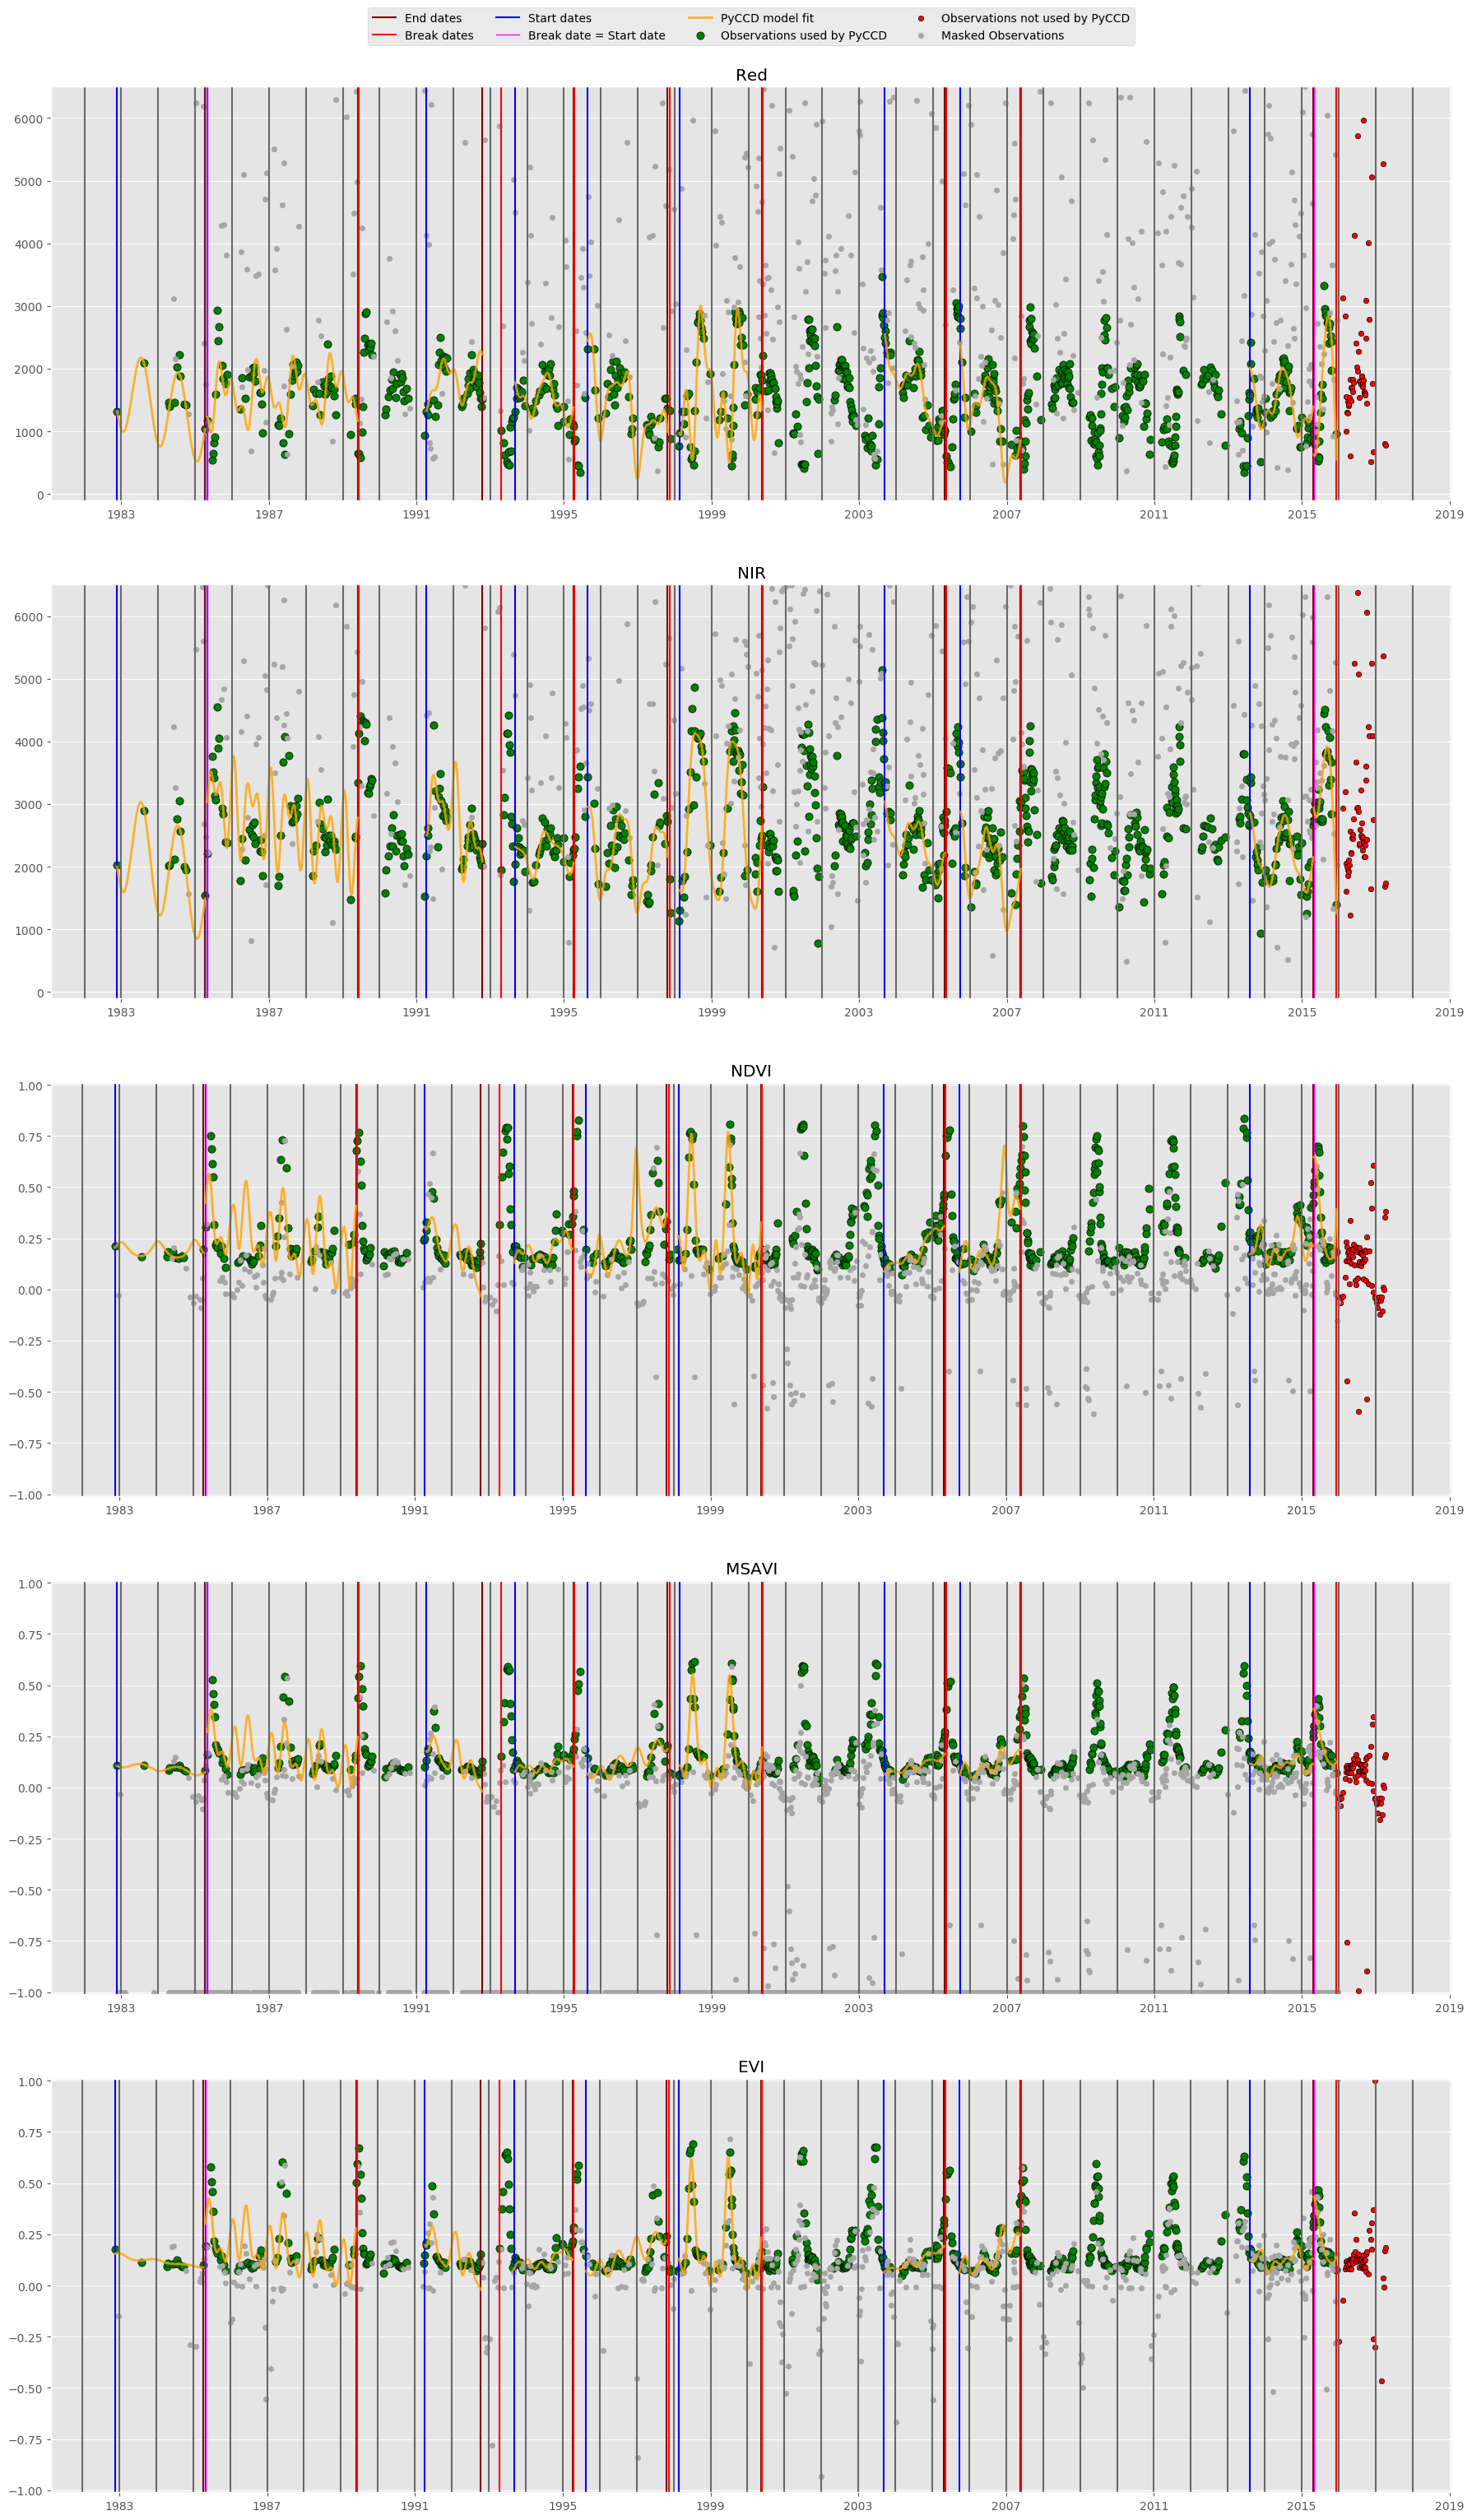

In [43]:
# Create the artist containers
fig, axes = plt.subplots(nrows=len(keys), ncols=1, figsize=(18, len(keys) * 6), dpi=100, squeeze=False)

for num, b in enumerate(keys):
    # Plot the observations within the PyCCD time range
    axes[num, 0].scatter(x=dates_in[total_mask], y=plot_data[b][0][date_mask][total_mask], s=44, c="green", edgecolors="black", 
                     label="Observations used by PyCCD")
    
    # Plot the observations outside of the PyCCD time range
    axes[num, 0].scatter(x=dates_out[fill_out], y=plot_data[b][0][~date_mask][fill_out], s=21, c="red", edgecolors="black", 
                      label="Observations not used by PyCCD")
    
    # Plot the observed values masked out by PyCCD
    if masked_on is True:
        
        #Remove the 0-valued masked obserations for the index plots
        if b in index_lookup.keys():
            index_plot = plot_data[b][0][date_mask][~ccd_mask]
            
            axes[num, 0].scatter(x=dates_in[~ccd_mask][index_plot != 0], y=index_plot[index_plot != 0], color="0.65",
                             s=21, label="Masked Observations")
            
        else:
            axes[num, 0].scatter(dates_in[~ccd_mask], plot_data[b][0][date_mask][~ccd_mask], color="0.65", 
                             s=21, label="Masked Observations")
            
    # Give each subplot a title
    axes[num, 0].set_title(f"{b}")
    
    # Plot the model start, end, and break days
    if model_on is True:
        # Get list of instances where break=start date
        match_dates = [b for b in break_dates for s in start_dates if b==s]
    
        for ind, e in enumerate(end_dates):
            if ind == 0:
                axes[num, 0].axvline(e, color="maroon", linewidth=1.5, label="End dates")
                
            else:
                # Plot without a label to remove duplicates in the legend
                axes[num, 0].axvline(e, color="maroon", linewidth=1.5)
                
        for ind, br in enumerate(break_dates):
            if ind == 0:
                axes[num, 0].axvline(br, color="r", linewidth=1.5, label="Break dates")
                
            else:
                axes[num, 0].axvline(br, color="r", linewidth=1.5)
                
        for ind, s in enumerate(start_dates):
            if ind == 0:
                axes[num, 0].axvline(s, color="b", linewidth=1.5, label="Start dates")
                
            else:
                axes[num, 0].axvline(s, color="b", linewidth=1.5)
                
        for ind, m in enumerate(match_dates):
            if ind == 0:
                axes[num, 0].axvline(m, color="magenta", linewidth=1, label="Break date = Start date")
                
            else:
                axes[num, 0].axvline(m, color="magenta", linewidth=1)
                
        # Predicted Curves
        for c in range(0, len(results["change_models"])):
            if c == 0:
                axes[num, 0].plot(prediction_dates[c * len(bands)], plot_data[b][1][c], "orange",
                                 linewidth=2, alpha=0.8, label="PyCCD model fit")
                
            else:
                axes[num, 0].plot(prediction_dates[c * len(bands)], plot_data[b][1][c], "orange",
                                 linewidth=2, alpha=0.8)
                
    # Get ymin and ymax values to constrain the plot window size
    if b in index_lookup.keys():
        # ymin = min(plot_data[b][0][date_mask][total_mask]) - 0.15
        # ymax = max(plot_data[b][0][date_mask][total_mask]) + 0.1
        ymin = -1.01
        ymax = 1.01
        
    elif b == "Thermal":
        ymin = -2500
        ymax = 6500

    else:
        # ymin = min(plot_data[b][0][date_mask][total_mask]) - 700
        # ymax = max(plot_data[b][0][date_mask][total_mask]) + 500
        ymin = -100
        ymax = 6500

    axes[num, 0].set_ylim([ymin, ymax])

    # Add x-ticks and x-tick_labels
    # axes[num, 0].set_xticks(ord_time)

    # axes[num, 0].set_xticklabels(x_labels, rotation=70, horizontalalignment="right")

    # Display the x and y values where the cursor is placed on a subplot
    axes[num, 0].format_coord = lambda x, y: "({0:f}, ".format(y) +  \
                                             "{0:%Y-%m-%d})".format(dt.datetime.fromordinal(int(x)))

    # Plot a vertical line at January 1 of each year on the time series
    for y in t_:
        axes[num, 0].axvline(y, color="dimgray", linewidth=1.5)

    # Only add a legend to the first subplot to avoid repetition and wasted space
    if b == list(keys)[0]:
        axes[num, 0].legend(ncol=4, loc="lower center", bbox_to_anchor=(0.5, 1.1),
                            borderaxespad=0.)
    
fig.tight_layout(h_pad=4)

In [45]:
len(fig.axes)

5